# Capstone Step 7 (14.8.1): Experiment With Various Models

## Final Data Preparation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

In [2]:
modeling_df = pd.read_csv(r'D:\MLE Capstone Project\Data\modeling_data.csv')

In [3]:
modeling_df = modeling_df.drop(columns=['DXCCSR_DEFAULT_DX1','MBD_dx','APRDRG','re_same_90','re_diff_90'])

In [4]:
modeling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795055 entries, 0 to 795054
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Primary_dx             795055 non-null  object 
 1   Secondary_dx           718689 non-null  object 
 2   APRDRG_Risk_Mortality  794644 non-null  float64
 3   APRDRG_Severity        794644 non-null  float64
 4   HOSP_BEDSIZE           795055 non-null  int64  
 5   H_CONTRL               795055 non-null  int64  
 6   HOSP_URCAT4            795055 non-null  int64  
 7   HOSP_UR_TEACH          795055 non-null  int64  
 8   N_DISC_U               795055 non-null  int64  
 9   N_HOSP_U               795055 non-null  int64  
 10  TOTAL_DISC             795055 non-null  int64  
 11  AGE                    795055 non-null  float64
 12  DIED                   793974 non-null  float64
 13  DISPUNIFORM            790457 non-null  float64
 14  DMONTH                 795055 non-nu

This dataset includes 795,055 unique admission records occuring within the first 9 months of the year; only patients who have an MBD (Mental, Behavioral, and Neurodevelopmental Disorder) as their primary diagnosis are included. Our EDA revealed that 58,562 patients (9.32%) were readmitted at least once for the same primary diagnosis, 31,860 patients (5.07%) were readmitted at least once for a different primary diagnosis, and 538,211 patients (85.62%) were never readmitted. The variables include basic information about the patient, medical diagnosis and severity information, and hospital information.

One of the first things we are going to do is reduce the dimensionality of some of the variables. First, we are going to reduce the dimensionality of the secondary diagnosis variable (which has 31,045 unique values) with clustering. Based on the elbow plot we created below, we are going to reduce this secondary diagnosis variable to 7 dimensions (plus missing). Second, we are going to reduce the procedure variable to a binary classification (yes/no) because there is no additional information available in this dataset about these procedures with which to reduce the dimensionality. Third, we are going to use one hot encoding to recode the primary diagnosis variable.

In [5]:
# Reducing the dataframe to the secondary diagnosis codes and diagnosis-related information
secondary_df = modeling_df[['APRDRG_Risk_Mortality','APRDRG_Severity','LOS','I10_NDX','I10_NPR','TOTCHG','avg_days_to_proc',
                            'Secondary_dx']]
secondary_df = secondary_df.groupby(by="Secondary_dx").mean()
for column in secondary_df:
    columnSeriesObj = secondary_df[column]
    col_mean = columnSeriesObj.mean()
    columnSeriesObj.fillna(value=col_mean, inplace=True)

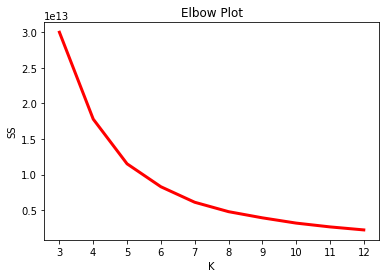

In [6]:
# Using K-Means clustering and an elbow plot to identify the optimal number of dimensions
x_cols = np.asarray(secondary_df)
centroids = list(range(3,13,1))
SS = []
for i in centroids:
    temp = KMeans(n_clusters=i, random_state=12).fit(x_cols)
    SS.append(temp.inertia_)
elbow_fig = plt.figure()
ax = elbow_fig.add_subplot(111)
ax.plot(centroids, SS, color='red', linewidth=3)
ax.set(title='Elbow Plot', xlabel='K', ylabel='SS')
ax.xaxis.set(ticks=centroids, ticklabels=centroids)
ax.grid(False)
plt.show()

In [7]:
# Creating a dataframe containing the cluster categories
cluster_model = KMeans(n_clusters=7, random_state=12).fit_predict(x_cols)
secondary_df['SDX_TYPE']=cluster_model
cluster_types = secondary_df.drop(columns=['APRDRG_Risk_Mortality','APRDRG_Severity','LOS','I10_NDX',
                                           'I10_NPR','TOTCHG','avg_days_to_proc']).reset_index()

In [8]:
# Adding the cluster categories to the modeling dataframe
modeling_df['SDX_TYPE'] = np.NaN
for dimension in range(0,7):
    reference_df = cluster_types[cluster_types.SDX_TYPE == dimension]
    modeling_df['SDX_TYPE'] = np.where(modeling_df['Secondary_dx'].isin(reference_df['Secondary_dx']), 
                                       dimension, modeling_df['SDX_TYPE'])
    print(f"Dimension {dimension} successfully added!")

Dimension 0 successfully added!
Dimension 1 successfully added!
Dimension 2 successfully added!
Dimension 3 successfully added!
Dimension 4 successfully added!
Dimension 5 successfully added!
Dimension 6 successfully added!


In [9]:
# Adding an eighth secondary diagnosis category (no comorbidities); no MBD comorbidities = 7
modeling_df['SDX_TYPE'] = np.where(modeling_df['SDX_TYPE'].isna(), 7, modeling_df['SDX_TYPE'])

In [10]:
# Changing the procedure code to a binary (yes/no) variable
modeling_df['PROCED'] = np.where(modeling_df['Procedure'].notna(), 1, 0)

In [11]:
# Changing missing values to a category code representing unknown
# 411 na for APRDRG_Risk_Mortality and APRDRG_Severity; recoded 0 = unknown
modeling_df['APRDRG_Risk_Mortality'] = np.where(modeling_df['APRDRG_Risk_Mortality'].isna(), 
                                                0, modeling_df['APRDRG_Risk_Mortality'])
modeling_df['APRDRG_Severity'] = np.where(modeling_df['APRDRG_Severity'].isna(), 
                                          0, modeling_df['APRDRG_Severity'])
# 4598 na for DISPUNIFORM; recoded 0 = unknown
modeling_df['DISPUNIFORM'] = np.where(modeling_df['DISPUNIFORM'].isna(), 0, modeling_df['DISPUNIFORM'])
# 1081 na for DIED; recoded 2 = unknown
modeling_df['DIED'] = np.where(modeling_df['DIED'].isna(), 2, modeling_df['DIED'])
# 2032 na for ELECTIVE; recoded 2 = unknown
modeling_df['ELECTIVE'] = np.where(modeling_df['ELECTIVE'].isna(), 2, modeling_df['ELECTIVE'])
# 1968 na for PAY1; recoded 0 = unknown
modeling_df['PAY1'] = np.where(modeling_df['PAY1'].isna(), 0, modeling_df['PAY1'])
# 17828 na for PL_NCHS; recoded 0 = unknown
modeling_df['PL_NCHS'] = np.where(modeling_df['PL_NCHS'].isna(), 0, modeling_df['PL_NCHS'])

# Replacing missing values with the column mean
# 112 na for LOS
# 656 na for TOTCHG
# 12120 na for ZIPINC_QRTL
for column in ['LOS','TOTCHG','ZIPINC_QRTL']:
    columnSeriesObj = modeling_df[column]
    col_mean = columnSeriesObj.mean()
    columnSeriesObj.fillna(value=col_mean, inplace=True)

In [12]:
# Removing the now redundant variables
modeling_df = modeling_df.drop(columns=['Secondary_dx','Procedure','avg_days_to_proc'])

In [13]:
# Stripping leading and trailing whitespace from primary diagnoses
modeling_df['Primary_dx'] = modeling_df.Primary_dx.apply(lambda x: x.strip() if isinstance(x, str) else x)

In [14]:
# Changing extremely rare (n < 20) combination primary diagnoses codes into the parent diagnosis code
modeling_df['Primary_dx'] = modeling_df.Primary_dx.apply(lambda x: 'MBD027' if x == 'MBD027 MBD029' else x)
modeling_df['Primary_dx'] = modeling_df.Primary_dx.apply(lambda x: 'MBD005' if x == 'MBD005 MBD022' else x)
modeling_df['Primary_dx'] = modeling_df.Primary_dx.apply(lambda x: 'MBD012' if x == 'MBD012 MBD023' else x)
modeling_df['Primary_dx'] = modeling_df.Primary_dx.apply(lambda x: 'MBD027' if x == 'MBD027 MBD028' else x)
modeling_df['Primary_dx'] = modeling_df.Primary_dx.apply(lambda x: 'MBD012' if x == 'MBD012 MBD021 MBD022' else x)
modeling_df['Primary_dx'] = modeling_df.Primary_dx.apply(lambda x: 'MBD001' if x == 'MBD001 MBD023' else x)
# Dropping extremely rare primary diagnosis codes
modeling_df = modeling_df[(modeling_df.Primary_dx != 'MBD028') & (modeling_df.Primary_dx != 'MBD029') & 
                          (modeling_df.Primary_dx != 'MBD030')]

In [15]:
# Dropping last 3 months of data from dmonth since our readmission window is 90 days
modeling_df = modeling_df[modeling_df.DMONTH <= 9]

In [16]:
# Saving the dataframe to a csv for quick reload
modeling_df.to_csv(r'D:\MLE Capstone Project\Data\modeling_data_prepared.csv', index=False)

## Automatic modeling

In [2]:
pip install mixed-naive-bayes

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from mixed_naive_bayes import MixedNB # Bernoulli and Gaussian implementation of NB
from sklearn.ensemble import HistGradientBoostingClassifier # LightGBM
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score # Performance metric
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
modeling_df = pd.read_csv(r'D:\MLE Capstone Project\Data\modeling_data_prepared.csv')

In [4]:
# Encoding categorical features for automatic modeling
categorical_data = modeling_df[['Primary_dx','APRDRG_Risk_Mortality','APRDRG_Severity','HOSP_BEDSIZE','H_CONTRL',
                                'HOSP_URCAT4','HOSP_UR_TEACH','DIED','DISPUNIFORM','DMONTH','ELECTIVE','FEMALE',
                                'HCUP_ED','PAY1','PL_NCHS','REHABTRANSFER','RESIDENT','SAMEDAYEVENT','ZIPINC_QRTL',
                                'SDX_TYPE','PROCED']]
cat_encoder = OneHotEncoder(drop='first',handle_unknown='ignore')
categorical_data = cat_encoder.fit_transform(categorical_data)
cat_labels = cat_encoder.get_feature_names_out(['Primary_dx','APRDRG_Risk_Mortality','APRDRG_Severity','HOSP_BEDSIZE',
                                                'H_CONTRL','HOSP_URCAT4','HOSP_UR_TEACH','DIED','DISPUNIFORM','DMONTH',
                                                'ELECTIVE','FEMALE','HCUP_ED','PAY1','PL_NCHS','REHABTRANSFER','RESIDENT',
                                                'SAMEDAYEVENT','ZIPINC_QRTL','SDX_TYPE','PROCED'])
categorical_data.shape

(628620, 112)

In [5]:
# Scaling continuous features for automatic modeling
continuous_data = modeling_df[['N_DISC_U','N_HOSP_U','TOTAL_DISC','AGE','LOS','I10_NDX','I10_NPR','TOTCHG']]
cont_scaler = StandardScaler()
continuous_data = cont_scaler.fit_transform(continuous_data)
cont_labels = cont_scaler.feature_names_in_
continuous_data.shape

(628620, 8)

In [6]:
# Preparing feature and label dataframes for analysis
cat_df = pd.DataFrame.sparse.from_spmatrix(categorical_data,columns=cat_labels)
cont_df = pd.DataFrame(data=continuous_data,columns=cont_labels)
X_df = cat_df.join(cont_df)
Y_df = modeling_df['re_any_90']
print(f"The features are shape {X_df.shape} and the labels are shape {Y_df.shape}.")

The features are shape (628620, 120) and the labels are shape (628620,).


We are going to build an automatic process to test several different ML classification algorithms on the observed data. For the purposes of this project, I have selected four different classification algorithms (i.e., logistic regression, naive bayes, gradient boosting, and random forest classification) using the scikit-learn package because these all scale relatively well to larger datasets. We are going to evaluate these classification algorithms using their F1 score because we care relatively equally about both precision (i.e., avoiding false positives; predicting readmission for those who were not readmitted) and recall (avoiding false negatives; failing to predict readmission for those who were actually readmitted). In a medical context, there are meaningful costs to both the hospital and patient care for both kinds of errors.

In [7]:
# Creating training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df,Y_df,stratify=Y_df,test_size=0.15,random_state=12)
# Identifying categorical features for mixed naive bayes and gradient boosting
cat_features = np.array(range(0,112))

In [9]:
# Suppressing an annoying warning
import warnings
warnings.filterwarnings("ignore", message="DataFrame with sparse columns found*")

In [18]:
# Creating an automatic model testing process
# Hyperparameters were adjusted to ensure convergence
Classifiers = [
    LogisticRegression(max_iter=250,C=0.01,class_weight='balanced',random_state=12,solver='sag'),
    MixedNB(categorical_features=cat_features),
    HistGradientBoostingClassifier(max_iter=500,learning_rate=0.2,max_depth=30,
                                   categorical_features=cat_features,random_state=12),
    RandomForestClassifier(max_depth=20,max_samples=0.5,class_weight='balanced',random_state=12)
]
prediction_number = 1
prediction_df = pd.DataFrame()
for classifier in Classifiers:
    clf = classifier
    clf.fit(X_train.values, y_train.values)
    predictions = clf.predict(X_test.values)
    prediction_df["yhat_%s" %prediction_number] = predictions
    prediction_number += 1   
print(f"The F1 score for logistic regression was {f1_score(y_test,prediction_df['yhat_1'])}.")
print(f"The F1 score for naive bayes was {f1_score(y_test,prediction_df['yhat_2'])}.")
print(f"The F1 score for gradient boosting was {f1_score(y_test,prediction_df['yhat_3'])}.")
print(f"The F1 score for random forest was {f1_score(y_test,prediction_df['yhat_4'])}.")

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2]
The F1 score for logistic regression was 0.307949520008629.
The F1 score for naive bayes was 0.08089030206677265.
The F1 score for gradient boosting was 0.004258443465491923.
The F1 score for random forest was 0.3044609665427509.


In [19]:
print(f"The precision for logistic regression was {precision_score(y_test,prediction_df['yhat_1'])}.")
print(f"The recall for logistic regression was {recall_score(y_test,prediction_df['yhat_1'])}.")
print(f"The precision for naive bayes was {precision_score(y_test,prediction_df['yhat_2'])}.")
print(f"The recall for naive bayes was {recall_score(y_test,prediction_df['yhat_2'])}.")
print(f"The precision for gradient boosting was {precision_score(y_test,prediction_df['yhat_3'])}.")
print(f"The recall for gradient boosting was {recall_score(y_test,prediction_df['yhat_3'])}.")
print(f"The precision for random forest was {precision_score(y_test,prediction_df['yhat_4'])}.")
print(f"The recall for random forest was {recall_score(y_test,prediction_df['yhat_4'])}.")

The precision for logistic regression was 0.2036231367234862.
The recall for logistic regression was 0.6314974563149746.
The precision for naive bayes was 0.29417206290471787.
The recall for naive bayes was 0.046892280468922805.
The precision for gradient boosting was 0.5087719298245614.
The recall for gradient boosting was 0.0021381700213817002.
The precision for random forest was 0.2379134332074532.
The recall for random forest was 0.42269409422694093.


None of the models achieved an especially high f1 score, but logistic regression and random forest achieved the best results. A closer look at precision and recall revealed that logistic regression and random forest did a little better with recall, whereas naive bayes and gradient boosting did better with precision. This gave me the idea to ensemble these models together by averaging their class probabilities and then tuning the decision threshold to further improve performance; threshold-moving can substantially improve classification performance in imbalanced data.

In [24]:
# Creating an ensemble of the different models.
Classifiers = [
    LogisticRegression(max_iter=250,C=0.01,class_weight='balanced',random_state=12,solver='sag'),
    MixedNB(categorical_features=cat_features),
    HistGradientBoostingClassifier(max_iter=500,learning_rate=0.2,max_depth=30,
                                   categorical_features=cat_features,random_state=12),
    RandomForestClassifier(max_depth=20,max_samples=0.5,class_weight='balanced',random_state=12)
]
prediction_number = 1
prediction_df = pd.DataFrame()
for classifier in Classifiers:
    clf = classifier
    clf.fit(X_train.values, y_train.values)
    p_re = clf.predict_proba(X_test.values)[:,1]
    prediction_df["prob_%s" %prediction_number] = p_re
    prediction_number += 1
prediction_df['Probability'] = prediction_df.mean(axis=1)
prediction_df['Actual'] = y_test.values

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2]


The Best Threshold = 0.279414, F1 Score = 0.322


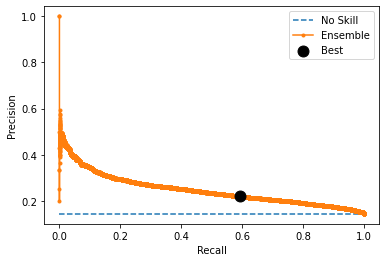

In [40]:
# Automatically finding the optimum decision threshold for the ensemble probabilities
from numpy import argmax
from sklearn.metrics import precision_recall_curve
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(prediction_df.Actual, prediction_df.Probability)
# Convert to F1 score
fscore = (2 * precision * recall) / (precision + recall)
# Locate the index of the largest F1 score
ix = argmax(fscore)
print('The Best Threshold = %f, F1 Score = %.3f' %(thresholds[ix], fscore[ix]))
# Plot the precision-recall curve
no_skill = len(prediction_df[prediction_df.Actual==1]) / len(prediction_df)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best', zorder=2.5, s=120)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Ensemble')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Using an ensemble method and tuning the decision threshold only modestly improved the F1 score. This approach could perhaps be improved by weighting how we average the probability estimates (according to some metric like accuracy), running the probability estimates through another algorithm, or improving each of these models by tuning their hyperparameters. We are going to start by building a cross-validation process for automatically tuning the hyperparameters for one of these models, the random forest. 

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Creating a parameter grid for random forest
n_estimators = [int(x) for x in np.linspace(100, 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
min_samples_split = [2,8]
min_samples_leaf = [1,4]
class_weight = ['balanced',None]
max_samples = [float(x) for x in np.linspace(0.2, 0.9, 8)]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight,
               'max_samples': max_samples}
pprint(random_grid)

{'class_weight': ['balanced', None],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'max_samples': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 8],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [45]:
# Instantiate and fit the random search model
rf_clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid, scoring = 'f1',
                               n_iter = 20, cv = 4, verbose=2, random_state=12, n_jobs = -1)
rf_random.fit(X_train.values, y_train.values)
rf_random.best_params_

Fitting 4 folds for each of 20 candidates, totalling 80 fits


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 0.3,
 'max_depth': 10,
 'class_weight': 'balanced'}

In [47]:
# Evaluating random forest model with tuned hyperparameters
opt_predict = rf_random.predict(X_test.values)
print(f"The F1 score for optimized random forest was {f1_score(y_test,opt_predict)}.")
print(f"The precision for optimized random forest was {precision_score(y_test,opt_predict)}.")
print(f"The recall for optimized random forest was {recall_score(y_test,opt_predict)}.")

The F1 score for optimized random forest was 0.3093114582424295.
The precision for optimized random forest was 0.20262050672276594.
The recall for optimized random forest was 0.6533215365332153.


In [11]:
# Checking how well the model generalized from train data to test data
best_model = RandomForestClassifier(n_estimators=1000,min_samples_split=2,min_samples_leaf=1,max_samples=0.3,
                                    max_depth=10,class_weight='balanced')
best_model.fit(X_train.values,y_train.values)
train_predict = best_model.predict(X_train.values)
test_predict = best_model.predict(X_test.values)
print(f"The F1 score for optimized random forest on training was {f1_score(y_train,train_predict)}.")
print(f"The F1 score for optimized random forest on testing was {f1_score(y_test,test_predict)}.")
print(f"The difference in these F1 scores is {f1_score(y_train,train_predict) - f1_score(y_test,test_predict)}.")

The F1 score for optimized random forest on training was 0.3197181710681908.
The F1 score for optimized random forest on testing was 0.3089019840301266.
The difference in these F1 scores is 0.010816187038064196.


The F1 score of the random forest model did not markedly improve with hyperparameter tuning using random grid search. It appears that while recall improved, precision got a little worse, and so on the whole the F1 score was relatively stable. The model generalized well from training to testing, so this also does not appear to be an issue with overfitting the data. The endemic error in this problem may be too high to achieve both high precision and high recall. While both are medically relevant, perhaps we should prioritize recall because this ensures that we correctly predict readmission for most patients who are actually readmitted (and we therefore accept a higher false positive rate).

In [53]:
# Refitting the random forest with tuned hyperparameters to get feature importances
best_model = RandomForestClassifier(n_estimators=1000,min_samples_split=2,min_samples_leaf=1,max_samples=0.3,
                                    max_depth=10,class_weight='balanced')
best_model.fit(X_train.values,y_train.values)
model_features_df = pd.DataFrame()
model_features_df['Gini'] = best_model.feature_importances_
model_features_df['Features'] = X_df.columns.values

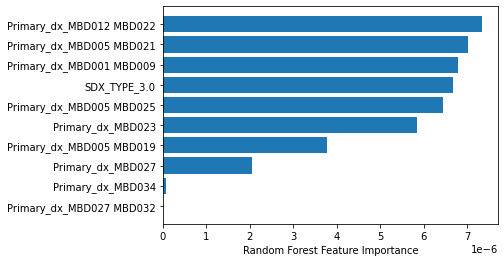

In [55]:
# Identifying the most important features
top_ten_features = model_features_df.sort_values(by='Gini')[:10]
plt.barh(top_ten_features.Features, top_ten_features.Gini)
plt.xlabel("Random Forest Feature Importance")
plt.show()

A closer inspection of the feature importances from the tuned random forest model revealed that a cluster of 7 primary diagnoses and one secondary diagnosis type were the most important features. It is interesting that none of the other types of information--such as demographics, encounter characteristics, or hospital characteristics--were nearly as important for classifying readmission as diagnosis alone.